# Convo LSTM Model
by Neural Network Ninjas (COMP9444)

z5444643 Vishesh Malik

z5012904 Arifah binti Anwar Fadzil

z5465111 Sathwik Bharadwaj Udupi

z5447832 Devarshi Prakashbhai Patel

z5435266 Bhuvan Tulani


# Section 1:
This is the 3rd model in our series. We created this model based on the study provided in the main code file (containg the working models), and then modified it as per our requirement to use video files.

This model gave only 40% accuracy hence we could not use it to predict real time exercises.

Note: While recreating this notebook for final submission we didn't have access to heavy computing units so we have created this model with simple video processing, ie. we have not preprocessed the data for this model as we have done in our other file for other two models.

During our testing phase when we ran this model with preprocessed data the accuracy of this model ranged in between 40-45%.

All the functions for this are taken from previous file

# Step 1
reading contents in file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing and predefining the data

In [2]:
#importing the header files and predefining the data
import os
import cv2
import json
import glob
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import deque
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from moviepy.editor import *
from IPython.display import *
!pip install ultralytics
from ultralytics import YOLO
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

img_height = 128
img_width = 128
frame = 20

seed_constant = 27
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)
random.seed(seed_constant)



# Specify the directory containing the UCF50 dataset.
Dataset = "/content/drive/MyDrive/dataset/input/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['overheadpress', 'squats', 'curls']



# Extracting frames from videos

In [3]:
def extract_frames(video_path):
  frame = 20
  frames = []
  capture = cv2.VideoCapture(video_path)
  count_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_step = int(count_frames/frame)
  skip_frame = max(skip_step, 1)
  for i in range(frame):
    capture.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frame)
    success, frame = capture.read()
    if not success:
        break
    size_image =(img_height, img_width)
    resize_f = cv2.resize(frame, size_image)
    norm_f = resize_f / 255
    frames.append(norm_f)
  capture.release()
  return frames

# Feature extraction

In [4]:
#extracting features from the videos
def features_creation():
    features = []
    labels = []
    vids = []

    for i, j in enumerate(CLASSES_LIST):
        files = os.listdir(os.path.join(Dataset, j))
        for file in files:
            video_file_path = os.path.join(Dataset, j, file)
            frames = extract_frames(video_file_path)
            if len(frames) == frame:
                features.append(frames)
                labels.append(i)
                vids.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, vids

In [5]:
features, labels, file_paths = features_creation()

In [6]:
onehot_labels = to_categorical(labels)

# Initializing the test size

In [7]:
features_train, features_test, labels_train, labels_test = train_test_split(features, onehot_labels, test_size = 0.10, shuffle = True, random_state = seed_constant)

# Defining the convoLSTM Model
The model includes a combination of ConvLSTM2d layers, 3D MaxPooling layers, TimeDistributed layers with Dropout, a Flatten layer, BatchNormalization, and a Dense layer for classification.

These layers make up a model for activity analysis in videos. The convoLSTM layers capture spatial and temporal features in the video. Whereas the pooling layers reduce dimensionality. The Dropout layer helps in prevention of overfitting, and batch normalization layer improves training stability of the model. The final dense layer produces a classification output.

In [8]:
def convlstm():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.

    model = Sequential([
        ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', data_format="channels_last",
                   recurrent_dropout=0.3, return_sequences=True, input_shape=(frame, img_height, img_width, 3)),

        MaxPooling3D(pool_size=(1, 3, 3), padding='same', data_format='channels_last'),
        TimeDistributed(Dropout(0.3)),

        ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', data_format="channels_last",
                   recurrent_dropout=0.3, return_sequences=True),

        MaxPooling3D(pool_size=(1, 3, 3), padding='same', data_format='channels_last'),
        TimeDistributed(Dropout(0.3)),

        Flatten(),
        BatchNormalization(),

        Dense(len(CLASSES_LIST), activation="sigmoid")
    ])

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model



# Defining the required data for the model

In [9]:
optimizer = Adam(learning_rate=0.0001)
convlstm_model = convlstm()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 126, 126, 16   11008     
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 42, 42, 16)    0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 42, 42, 16)    0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 40, 40, 32)    55424     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 14, 14, 32)    0         
 g3D)                                                 

# Defining required parameters and evaluating the results

In [10]:
#earLy stopping
early = {
    'monitor': 'val_accuracy',
    'patience': 10,
    'mode': 'max',
    'restore_best_weights': True
}
early_stop = EarlyStopping(**early)

#initializing values to compile
comp = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'Adam',
    'metrics': ["accuracy"]
}
convlstm_model.compile(**comp)

#Training the model
fit = {
    'x': features_train,
    'y': labels_train,
    'epochs': 100,
    'batch_size': 4,
    'shuffle': True,
    'validation_split': 0.2,
    'callbacks': [early_stop]
}
convlstm_model_training_history = convlstm_model.fit(**fit)



Epoch 1/100
54/54 [==============================] - 42s 289ms/step - loss: 1.6974 - accuracy: 0.3426 - val_loss: 1.1212 - val_accuracy: 0.2778
Epoch 2/100
54/54 [==============================] - 13s 250ms/step - loss: 1.1467 - accuracy: 0.3935 - val_loss: 1.1321 - val_accuracy: 0.4074
Epoch 3/100
54/54 [==============================] - 13s 243ms/step - loss: 1.2054 - accuracy: 0.3148 - val_loss: 1.1223 - val_accuracy: 0.2778
Epoch 4/100
54/54 [==============================] - 15s 270ms/step - loss: 1.0819 - accuracy: 0.4583 - val_loss: 1.4929 - val_accuracy: 0.3148
Epoch 5/100
54/54 [==============================] - 14s 261ms/step - loss: 1.1608 - accuracy: 0.4491 - val_loss: 1.4546 - val_accuracy: 0.3148
Epoch 6/100
54/54 [==============================] - 14s 255ms/step - loss: 1.0530 - accuracy: 0.4444 - val_loss: 1.1430 - val_accuracy: 0.2593
Epoch 7/100
54/54 [==============================] - 14s 255ms/step - loss: 1.1268 - accuracy: 0.5278 - val_loss: 1.3437 - val_accuracy:

the Model results are as follows:
1/1 [==============================] - 1s 735ms/step - loss: 1.1866 - accuracy: 0.3667


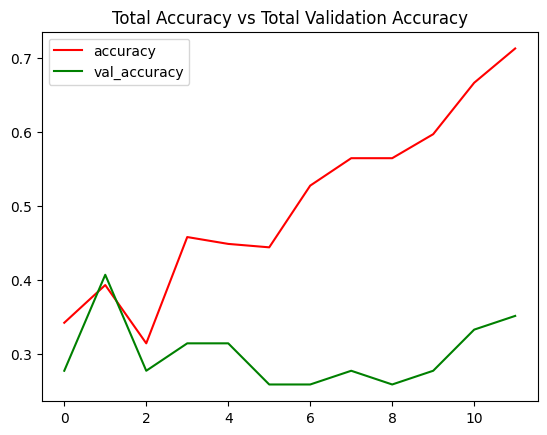

In [11]:
print("the Model results are as follows:")
#Evaluating the model
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
# Get metric values using metric names as identifiers.
a = 'accuracy'
b = 'val_accuracy'
a1 = convlstm_model_training_history.history[a]
b1 = convlstm_model_training_history.history[b]

# Construct a range object which will be used as x-axis (horizontal plane) of the graph.
epochs = range(len(a1))

# Plot the Graph.
plt.plot(epochs, a1, 'red', label=a)
plt.plot(epochs, b1, 'green', label=b)

# Add title to the plot.
plt.title('Total Accuracy vs Total Validation Accuracy')

# Add legend to the plot.
plt.legend()

# Show the plot
plt.show()


# Results
This model has given 36% accuracy, which is nearby when we were testing accuracy for it. And after preprocessing of images we expect to see a rise in accuracy of the model by 5-6%.